In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import data_processing
%matplotlib inline

/home/torres/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data = data_processing.load_data(download=False)
new_data = data_processing.convertToOnehot(data)

# prepare training data
new_data = new_data.values.astype(np.float32) # change to numpy array and float32 [pandas to numpy(float 32)]
np.random.shuffle(new_data)
sep = int(0.7*len(new_data))
train_data = new_data[:sep]
test_data = new_data[sep:]

In [5]:
# build network
tf_input = tf.placeholder(tf.float32, [None, 25], "input")
tfx = tf_input[:, :21]
tfy = tf_input[:, 21:]

l1 = tf.layers.dense(tfx, 128, tf.nn.relu, name="l1")
l2 = tf.layers.dense(l1, 128, tf.nn.relu, name="l2")
out = tf.layers.dense(l2, 4, name="l3")
prediction = tf.nn.softmax(out, name="pred")

# logits是没有经过softmax的prediction，tf会自动给你过一层softmax
loss = tf.losses.softmax_cross_entropy(onehot_labels=tfy, logits=out)

# argmax是为了找出tfy中每行数据对应的汽车状态和out中最有可能的汽车状态
# tf.metrics.accuracy(...)[0]和[1]分别是什么？ [https://www.tensorflow.org/api_docs/python/tf/metrics/accuracy]
# ==> accuracy: A Tensor representing the accuracy, the value of total divided by count.
#     update_op: An operation that increments the total and count variables appropriately and whose value matches accuracy.
accuracy = tf.metrics.accuracy(          # return (acc, update_op), and create 2 local variables
    labels=tf.argmax(tfy, axis=1), predictions=tf.argmax(out, axis=1),)[1]

opt = tf.train.GradientDescentOptimizer(learning_rate=0.1)
train_op = opt.minimize(loss)

sess = tf.Session()
sess.run(tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()))

Step: 0 | Accurate: 0.622351 | Loss: 1.29


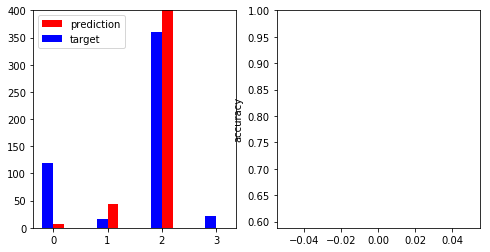

Step: 50 | Accurate: 0.657996 | Loss: 0.61
Step: 100 | Accurate: 0.719974 | Loss: 0.39
Step: 150 | Accurate: 0.760597 | Loss: 0.29
Step: 200 | Accurate: 0.789595 | Loss: 0.24
Step: 250 | Accurate: 0.809570 | Loss: 0.21
Step: 300 | Accurate: 0.828241 | Loss: 0.18
Step: 350 | Accurate: 0.842967 | Loss: 0.17
Step: 400 | Accurate: 0.853779 | Loss: 0.16
Step: 450 | Accurate: 0.864547 | Loss: 0.13
Step: 500 | Accurate: 0.873183 | Loss: 0.11
Step: 550 | Accurate: 0.881663 | Loss: 0.10
Step: 600 | Accurate: 0.887654 | Loss: 0.11
Step: 650 | Accurate: 0.894027 | Loss: 0.08
Step: 700 | Accurate: 0.899679 | Loss: 0.08
Step: 750 | Accurate: 0.904745 | Loss: 0.07
Step: 800 | Accurate: 0.908988 | Loss: 0.07
Step: 850 | Accurate: 0.913081 | Loss: 0.06
Step: 900 | Accurate: 0.916844 | Loss: 0.06
Step: 950 | Accurate: 0.920135 | Loss: 0.06
Step: 1000 | Accurate: 0.923296 | Loss: 0.06
Step: 1050 | Accurate: 0.926169 | Loss: 0.05
Step: 1100 | Accurate: 0.928877 | Loss: 0.05
Step: 1150 | Accurate: 0.93111

In [6]:
# training
plt.ion()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
accuracies, steps = [], []
for t in range(4000):
    # training
    batch_index = np.random.randint(len(train_data), size=32)
    sess.run(train_op, {tf_input: train_data[batch_index]})

    if t % 50 == 0:
        # testing
        acc_, pred_, loss_ = sess.run([accuracy, prediction, loss], {tf_input: test_data})
        accuracies.append(acc_)
        steps.append(t)
        print("Step: %i" % t,"| Accurate: %.6f" % acc_,"| Loss: %.2f" % loss_,)

        # visualize testing
        ax1.cla()
        for c in range(4):
            bp = ax1.bar(c+0.1, height=sum((np.argmax(pred_, axis=1) == c)), width=0.2, color='red')
            bt = ax1.bar(c-0.1, height=sum((np.argmax(test_data[:, 21:], axis=1) == c)), width=0.2, color='blue')
        ax1.set_xticks(range(4), ["accepted", "good", "unaccepted", "very good"])
        ax1.legend(handles=[bp, bt], labels=["prediction", "target"])
        ax1.set_ylim((0, 400))
        ax2.cla()
        ax2.plot(steps, accuracies, label="accuracy")
        ax2.set_ylim(ymax=1)
        ax2.set_ylabel("accuracy")
        plt.pause(0.01)

plt.ioff()
plt.show()